✅ Archivos cargados


,Person ID,Gender,Age,Occupation,Sleep Duration,Quality of Sleep,Physical Activity Level,BMI Category,Blood Pressure,Heart Rate,Daily Steps,Sleep Disorder,stress_binary
0,317,Female,53,Engineer,8.5,9,30,Normal,125/80,65,5000,NaN,0
1,283,Female,50,Nurse,6.0,6,90,Overweight,140/95,75,10000,Sleep Apnea,1
2,309,Female,52,Accountant,6.6,7,45,Overweight,130/85,72,6000,Insomnia,1
3,276,Female,49,Nurse,6.2,6,90,Overweight,140/95,75,10000,Sleep Apnea,1
4,243,Male,44,Salesperson,6.4,6,45,Overweight,130/85,72,6000,Insomnia,1


✅ Métricas comparativas


,Model,Accuracy,Precision,Recall,F1
0,RandomForest,1.000000,1.0,1.000000,1.000000
1,GradientBoosting,0.972222,1.0,0.909091,0.952381
2,LogisticRegression,0.972222,1.0,0.909091,0.952381
3,SVM,0.972222,1.0,0.909091,0.952381


✅ Mejor modelo: RandomForest


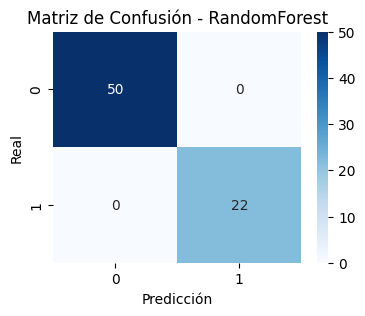

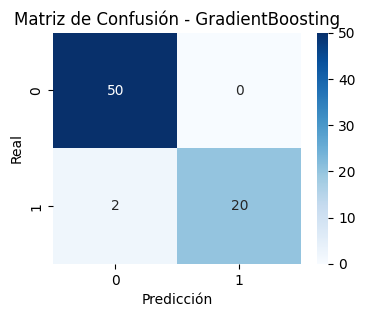

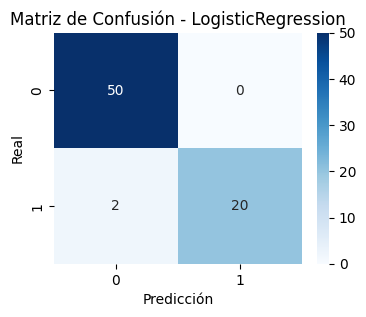

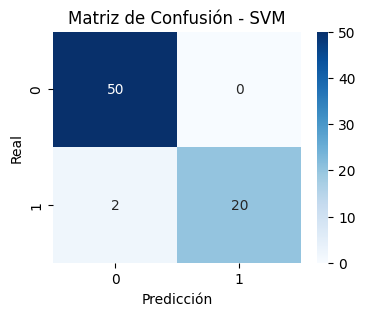

[🌐 Abrir la app permanente en Hugging Face](https://huggingface.co/spaces/Amymarlene/stress-prediction)

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://7c9595341b228e6308.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [10]:
# 💤 CLASIFICACIÓN BINARIA – ANÁLISIS DE ESTILOS Y PATRONES DE SUEÑO
# Elaborado por: Amy Frías
# Incluye 4 modelos, análisis de errores, métricas comparativas y Gradio UI

# ======================================================
# 🔹 1. Librerías
# ======================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import gradio as gr

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

# ======================================================
# 🔹 2. Cargar archivos CSV
# ======================================================
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
print("✅ Archivos cargados")
display(train.head())

# ======================================================
# 🔹 3. Preprocesamiento
# ======================================================
# Copias
train_copy = train.copy()
test_copy = test.copy()

# Combinar para LabelEncoder
combined = pd.concat([train_copy, test_copy], axis=0)
categorical_cols = ["Gender", "Occupation", "BMI Category", "Blood Pressure", "Sleep Disorder"]

label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    le.fit(combined[col].astype(str))
    train_copy[col] = le.transform(train_copy[col].astype(str))
    test_copy[col] = le.transform(test_copy[col].astype(str))
    label_encoders[col] = le

# Variables predictoras y objetivo
X_train = train_copy.drop(["Person ID", "stress_binary"], axis=1)
y_train = train_copy["stress_binary"]
X_test = test_copy.drop(["Person ID", "stress_binary"], axis=1)
y_test = test_copy["stress_binary"]

# Escalado para modelos que lo necesitan
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# ======================================================
# 🔹 4. Entrenamiento de modelos
# ======================================================
models = {
    "RandomForest": RandomForestClassifier(n_estimators=150, random_state=42),
    "GradientBoosting": GradientBoostingClassifier(n_estimators=150, random_state=42),
    "LogisticRegression": LogisticRegression(max_iter=1000),
    "SVM": SVC(probability=True)
}

metrics = []
y_preds = {}

for name, model in models.items():
    if name in ["LogisticRegression", "SVM"]:
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    metrics.append([name, acc, prec, rec, f1])
    y_preds[name] = y_pred

metrics_df = pd.DataFrame(metrics, columns=["Model","Accuracy","Precision","Recall","F1"])
print("✅ Métricas comparativas")
display(metrics_df)

# Elegir mejor modelo según F1
best_model_name = metrics_df.sort_values("F1", ascending=False).iloc[0]["Model"]
best_model = models[best_model_name]
print(f"✅ Mejor modelo: {best_model_name}")

# Guardar modelo y encoders
joblib.dump(best_model, "best_model.joblib")
joblib.dump(label_encoders, "label_encoders.pkl")

# ======================================================
# 🔹 5. Análisis de errores (matrices de confusión)
# ======================================================
for name, y_pred in y_preds.items():
    plt.figure(figsize=(4,3))
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap="Blues")
    plt.title(f"Matriz de Confusión - {name}")
    plt.xlabel("Predicción")
    plt.ylabel("Real")
    plt.show()

# ======================================================
# 🔹 6. Función para Gradio
# ======================================================
def predecir_estres(Person_ID, Gender, Age, Occupation, Sleep_Duration, Quality_of_Sleep,
                    Physical_Activity_Level, BMI_Category, Blood_Pressure, Heart_Rate,
                    Daily_Steps, Sleep_Disorder):

    entrada = pd.DataFrame({
        "Gender": [label_encoders["Gender"].transform([Gender])[0]],
        "Age": [Age],
        "Occupation": [label_encoders["Occupation"].transform([Occupation])[0]],
        "Sleep Duration": [Sleep_Duration],
        "Quality of Sleep": [Quality_of_Sleep],
        "Physical Activity Level": [Physical_Activity_Level],
        "BMI Category": [label_encoders["BMI Category"].transform([BMI_Category])[0]],
        "Blood Pressure": [label_encoders["Blood Pressure"].transform([Blood_Pressure])[0]],
        "Heart Rate": [Heart_Rate],
        "Daily Steps": [Daily_Steps],
        "Sleep Disorder": [label_encoders["Sleep Disorder"].transform([Sleep_Disorder])[0]]
    })

    # Escalado para modelos que lo necesitan
    if best_model_name in ["LogisticRegression", "SVM"]:
        entrada_scaled = scaler.transform(entrada)
        pred = best_model.predict(entrada_scaled)[0]
    else:
        pred = best_model.predict(entrada)[0]

    return "😌 Sin Estrés" if pred == 0 else "⚠️ Con Estrés"

# ======================================================
# 🔹 7. Mostrar link permanente Hugging Face
# ======================================================
hugging_link = "https://huggingface.co/spaces/Amymarlene/stress-prediction"
display(Markdown(f"[🌐 Abrir la app permanente en Hugging Face]({hugging_link})"))

# ======================================================
# 🔹 8. Interfaz Gradio
# ======================================================
with gr.Blocks(theme="soft") as interfaz:
    gr.Markdown("## 🧠 Predicción de Estrés según Hábitos de Sueño")
    gr.Markdown("Ingrese los datos para predecir si existe estrés (0 = No, 1 = Sí)")

    with gr.Row():
        Person_ID = gr.Number(label="Person ID", value=1)
        Gender = gr.Dropdown(sorted(train["Gender"].unique().tolist()), label="Gender")
        Age = gr.Slider(18, 60, value=25, step=1, label="Age")
        Occupation = gr.Dropdown(sorted(train["Occupation"].unique().tolist()), label="Occupation")

    with gr.Row():
        Sleep_Duration = gr.Slider(4, 9, value=7, step=0.1, label="Sleep Duration (horas)")
        Quality_of_Sleep = gr.Slider(3, 10, value=7, step=1, label="Quality of Sleep")
        Physical_Activity_Level = gr.Slider(0, 10, value=5, step=1, label="Physical Activity Level")

    with gr.Row():
        BMI_Category = gr.Dropdown(sorted(train["BMI Category"].unique().tolist()), label="BMI Category")
        Blood_Pressure = gr.Dropdown(sorted(train["Blood Pressure"].unique().tolist()), label="Blood Pressure")
        Heart_Rate = gr.Number(label="Heart Rate")
        Daily_Steps = gr.Number(label="Daily Steps")
        Sleep_Disorder = gr.Dropdown(sorted([str(x) for x in train["Sleep Disorder"].unique().tolist()]), label="Sleep Disorder")

    boton = gr.Button("🔍 Predecir Estrés")
    salida = gr.Textbox(label="Resultado")

    boton.click(fn=predecir_estres,
                inputs=[Person_ID, Gender, Age, Occupation, Sleep_Duration, Quality_of_Sleep,
                        Physical_Activity_Level, BMI_Category, Blood_Pressure, Heart_Rate,
                        Daily_Steps, Sleep_Disorder],
                outputs=salida)

# ======================================================
# 🔹 9. Ejecutar Gradio en Colab con share=True
# ======================================================
interfaz.launch(share=True)
